# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [7]:
# import the needed packages
import torch
import torch.nn.functional as F
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models

from PIL import Image

import numpy as np

import json

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [8]:
# Images folders
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [9]:
# training data: random scaling, cropping, flipping, resized data to 224x224
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# testing and validation: resize and crop to the appropriate size
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [10]:
# Load the datasets with ImageFolder
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)
valid_data = datasets.ImageFolder(valid_dir, transform=test_transforms) # use test_transforms

In [11]:
# Define the dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=64)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

One last important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to
GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module.

**Note for Workspace users:** If your network is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. Typically this happens with wide dense layers after the convolutional layers. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [12]:
# Load densenet model - chosen after several tests
model = models.vgg16(pretrained=True)

# Observe the classifier
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:38<00:00, 14487052.50it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [13]:
# Use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
# Load the model
model = models.vgg16(pretrained=True) 

In [15]:
# Freeze the features parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [16]:
# Replacing the classifier with our own one
# input size: 1024, same as in_features from the Classifier observed
# output size: 102, same as number of classes of items in the json file
# The other parameters came from test and adaptation
model.classifier = nn.Sequential(nn.Linear(25088, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.05),
                                 nn.Linear(512, 102),
                                 nn.LogSoftmax(dim=1))

In [17]:
# Generate criterion
criterion = nn.NLLLoss()

In [18]:
# Train the classifier parameters, feature parameters are frozen
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [19]:
# Move the model to the available device
model.to(device);

In [20]:
# Define variables we use for the training

# Set epochs
epochs = 3

# Number of train steps, so we track it
steps = 0

# Track the loss, so set to zero
running_loss = 0

# Steps we want to go before print out the validation loss
print_every = 5

In [21]:
# Training, looping through the epochs
for epoch in range(epochs):
    
    # looping through the data to train
    for inputs, labels in trainloader:
        # increment steps each time
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        # zero our gradients
        optimizer.zero_grad() 
        # Get our log probabilties from our model
        logps = model.forward(inputs) 
        # Get loss from the criterion on the labels
        loss = criterion(logps, labels) 
        # Backward pass
        loss.backward() 
        # Take a step with the optimizer
        optimizer.step() 
        # keep track of our training loss
        running_loss += loss.item() 
        
        # Drop out to the training loop and test the network
        # accuracy and loss on our test dataset
        
        # if zero, we go into the validation loop
        if steps % print_every == 0:
            valid_loss = 0
            accuracy = 0
            # Turn the model into evaluation inference mode which turns off dropout
            # so we can use the network to make predictions instead a test loss and accuracy
            model.eval()
            with torch.no_grad():
                # Get images and label from the validation data
                for inputs, labels in validloader:
                    # Transfer tensors over to the GPU
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    # Keep track of our loss to test 
                    valid_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Validation loss: {valid_loss/len(validloader):.3f}.. "
                  f"Validation accuracy: {accuracy/len(validloader):.3f}")
            
            # Reinit running loss
            running_loss = 0
            # Put the model back into training mode
            model.train()

Epoch 1/3.. Train loss: 4.914.. Validation loss: 4.061.. Validation accuracy: 0.176
Epoch 1/3.. Train loss: 4.052.. Validation loss: 3.350.. Validation accuracy: 0.288
Epoch 1/3.. Train loss: 3.598.. Validation loss: 2.769.. Validation accuracy: 0.401
Epoch 1/3.. Train loss: 3.250.. Validation loss: 2.486.. Validation accuracy: 0.455
Epoch 1/3.. Train loss: 2.852.. Validation loss: 2.054.. Validation accuracy: 0.518
Epoch 1/3.. Train loss: 2.453.. Validation loss: 1.813.. Validation accuracy: 0.570
Epoch 1/3.. Train loss: 2.273.. Validation loss: 1.684.. Validation accuracy: 0.570
Epoch 1/3.. Train loss: 2.094.. Validation loss: 1.276.. Validation accuracy: 0.671
Epoch 1/3.. Train loss: 1.825.. Validation loss: 1.143.. Validation accuracy: 0.707
Epoch 1/3.. Train loss: 1.777.. Validation loss: 1.169.. Validation accuracy: 0.689
Epoch 1/3.. Train loss: 1.654.. Validation loss: 1.076.. Validation accuracy: 0.706
Epoch 1/3.. Train loss: 1.483.. Validation loss: 0.905.. Validation accuracy

## Testing the network   

As a good practice, after training and validation respectively on training and validation data, we test the trained network on testing data, never seen either in training nor validation.

In [22]:
# Use the GPU if available - in case you run the notebook from the testing part
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# See how the network perform on test data
# Source: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        
        # Transfer to the available device
        images, labels = images.to(device), labels.to(device)
        
        # Probabilities
        outputs = model(images)
        
        # From probabilities to predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Sum up to get the number of images
        total += labels.size(0)
        
        # Counting correct predictions
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 86 %


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [24]:
# Observe the model
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys())

Our model: 

 VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  

In [25]:
# Get the mapping of classes to indices
model.class_to_idx = train_data.class_to_idx

In [26]:
# Create the checkpoint
# Reference: Course Notebook about Save and Loading Models - Part 6
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'epochs': epochs,
              'model_name': 'vgg16',
              'classifier': model.classifier,
              'class_to_idx': model.class_to_idx,
              'optimizer_state': optimizer.state_dict(),
              'state_dict': model.state_dict()}

In [27]:
# Save the model
torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [28]:
# Function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    ''' Create a model, with the classifier using the checkpoint file path
        Return the model
    '''
    checkpoint = torch.load(filepath)
    model = getattr(models, checkpoint['model_name'])(pretrained=True)
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [29]:
# Process images in the same manner used for training
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    processing = transforms.Compose([transforms.Resize(256), 
                                     transforms.CenterCrop(224), 
                                     transforms.ToTensor(), 
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                          std=[0.229, 0.224, 0.225])])
    
    image = processing(image)
   
    return image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [30]:
# converts a PyTorch tensor and displays it in the notebook
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

In [31]:
# Now select one image for our testing : flowers/valid/5/image_05209.jpg

![Selected Image for Testing](flowers/valid/5/image_05209.jpg)

torch.Size([3, 224, 224])


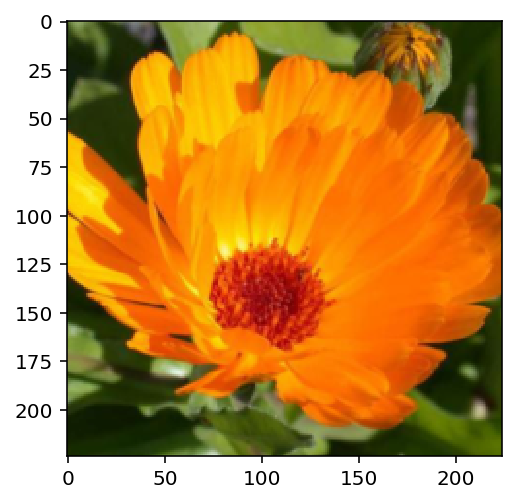

In [32]:
# Get the image
original_image = Image.open('flowers/valid/5/image_05209.jpg')

# Process through our preprocessing function
test_image = process_image(original_image)

# Show out the dimensions
print(test_image.shape)

# Show using the verification function
imshow(test_image);

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [33]:
# Use the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
# Predict the class from an image file
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # Reload our model
    rebuilt_model = load_checkpoint(model)
    
    # Mode the model to the default device
    rebuilt_model = rebuilt_model.to(device)
    
    # Pre-process the image to use
    processed_image = process_image(Image.open(image_path))
    
    # Convert it: Torch tensor via array
    processed_image = torch.from_numpy(np.array(processed_image))
    
    # Add dimension to the image
    processed_image = processed_image.unsqueeze_(0)
    
    # Put model to evaluation mode
    rebuilt_model.eval()
    
    # Move the image to the available device
    processed_image = processed_image.to(device)
    
    # Turn off gradients, send image through network
    with torch.no_grad():
        output = rebuilt_model.forward(processed_image)
    
    # Get the probabilities
    probabilities = torch.exp(output)
    
    # Extract the probabilities
    probs = probabilities.topk(topk)[0]
    index = probabilities.topk(topk)[1]
    
    # Convert them to list
    probs = np.array(probs)[0]
    index = np.array(index)[0]
    
    # Now get our index, class mapping from model
    class_to_idx = rebuilt_model.class_to_idx
    
    # Invert the dictionnary
    inv_class_to_idx = {x: y for y, x in class_to_idx.items()}
    
    # Convert index to class
    classes = []
    for element in index:
        classes += [inv_class_to_idx[element]]
        
    return probs, classes

## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

### Label mapping

Each of the objects contained in `cat_to_name.json` file, is a mapping of an integer and flower name.

In [35]:
# Build a dictionnary - from cat_to_name.json - mapping the integer to the flower names
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

### Prediction testing

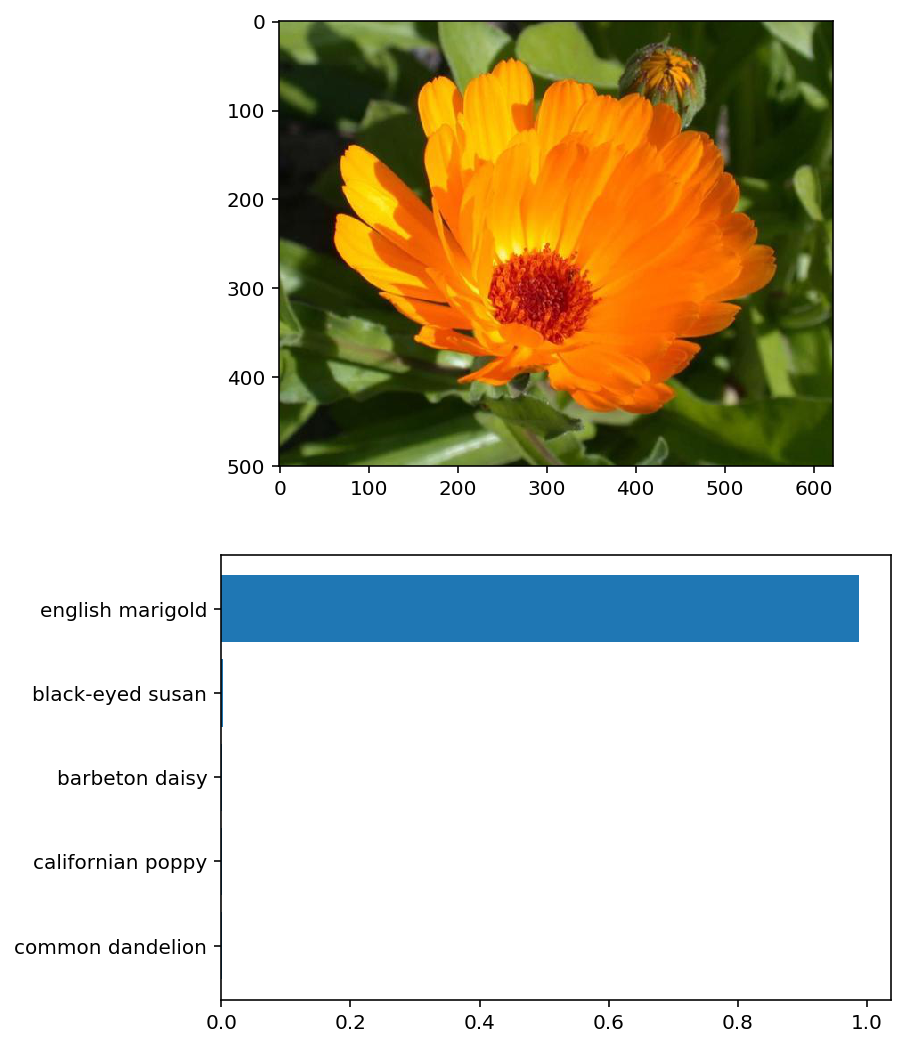

In [36]:
# Display an image along with the top 5 classes
probs, classes = predict('flowers/valid/5/image_05209.jpg', 'checkpoint.pth', topk=5)

# Get image names from the json file
species = []
for i in classes:
    species += [cat_to_name[i]]

# Inspired from the view_classify function in helper.py, from the course
fig, ax1 = plt.subplots(2, figsize = (6, 9))
ax1[0].imshow(Image.open('flowers/valid/5/image_05209.jpg'))

y_names = np.arange(len(species))
ax1[1].barh(y_names, probs)
ax1[1].set_yticks(y_names)
ax1[1].set_yticklabels(species)
ax1[1].invert_yaxis() 

# Show the image
plt.show()

References:   
Files `fc_model.py` and `hepler.py` from Lesson 4.   
All the notebooks from Lesson 4.  
https://pytorch.org/docs/stable/_modules/torchvision/models/densenet.html   
https://pytorch.org/docs/stable/_modules/torchvision/models/vgg.html   
https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html   
https://pytorch.org/tutorials/beginner/saving_loading_models.html   
https://pytorch.org/tutorials/beginner/ptcheat.html

To resolve problems:  
https://stackoverflow.com/questions/51891743/runtimeerror-size-mismatch-m1-672-x-224-m2-672-x-224


In [37]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Image_Classifier_Project.ipynb'])

0